<h1><center>DeepCor Tutorial</center></h1>

<!-- ### Outline
1. Installation
2. Example on the BrainIAK simulated dataset
2.1 Import modules
2.2 Load the data
2.3 Training with the DeepCor
2.4 Evaluation with the ground truth
3. Example on the real resting fMRI
3.1 Import modules
3.2 Load the data
3.3 Training with the DeepCor
3.4 Visualization
4. Example on the real task fMRI
4.1 Import modules
4.2 Load the data
4.3 Training with the DeepCor
4.4 Evaluation with the face regressor -->

### Outline
1. Installation
2. Example on the BrainIAK simulated dataset
3. Example on the real resting fMRI



### 1. Installation
To install DeepCor package you must make sure that your python version is over 3.9.=. If you don’t know the version of python you can check it by:

In [3]:
import platform
platform.python_version()

'3.9.16'

and once the python version matched the requirement, you can install DeepCor in either a python or Conda envirnoment through running the following code in bash:

```bash
git clone https://github.com/sccnlab/DeepCor/tree/main
cd DeepCor/DeepCor_package/
pip install --user .

### 2. Example on the BrainIAK Simulated Dataset

This section demonstrates how to run **DeepCor** on the BrainIAK simulated dataset.

Due to data privacy concerns related to the anatomical probability maps, we provide preprocessed input files instead. These files include:

- `./sample_data/BrainIAK_obs_list.csv`: Time series data from **regions-of-interest (ROIs)**.
- `./sample_data/BrainIAK_noi_list.csv`: Time series data from **regions-of-not-interest (RONIs)**.
- `./sample_data/BrainIAK_gt_list.csv`: The **ground truth signal**, available due to the simulation setup.

These CSV files represent matrix-formatted time course data and can be directly loaded for training and evaluation using DeepCor.

In the following steps, we will:
1. Import the necessary modules
2. Load the simulated data
3. Train the DeepCor model
4. Evaluate the predictions against the ground truth

#### 2.1 Import python modules

In [2]:
import DeepCor
import torch
import numpy as np
import random
import os
from torch.utils.data import random_split
from numpy import savetxt

#### 2.2 Load the data
Now we first set up the saving directory and load the preprocessed time series from both ROIs and RONI, along the grounth truth signals of ROI observations.

In [4]:
# create the output path if not exist
output_path = './results/BrinIAK_simulation/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [5]:
# load the dataset
data_path = './sample_data/BrainIAK_'
gt_list = np.loadtxt(f'{data_path}gt_list.csv', delimiter=",", dtype=float)
obs_list = np.loadtxt(f'{data_path}obs_list.csv', delimiter=",", dtype=float)
noi_list = np.loadtxt(f'{data_path}noi_list.csv', delimiter=",", dtype=float)

Then we randomly split the data into training (70%), validation (15%) and testing (15%).

In [6]:
# initiate the Dataset for easy training purpose
inputs_all = DeepCor.TrainDataset(obs_list, gt_list, noi_list)

In [7]:
# Randomly select certain amounts of samples
train_num = int(0.70*obs_list.shape[0])
val_num = int(0.15*obs_list.shape[0])
test_num = int(0.15*obs_list.shape[0])
total_num_samples = val_num + test_num + train_num
selected_indices = np.random.choice(len(inputs_all), size=total_num_samples, replace=False)
selected_samples = torch.utils.data.Subset(inputs_all, selected_indices)

generator = torch.Generator().manual_seed(42)
train_inputs, val_inputs, test_inputs = random_split(selected_samples, [train_num, val_num, test_num], generator=generator)
print("Train number is "+str(len(train_inputs)))
print("Val number is "+str(len(val_inputs)))
print("Test number is "+str(len(test_inputs)))

Train number is 10835
Val number is 2321
Test number is 2321


In [8]:
# dataloading
batch_size = 64
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size, shuffle=True, num_workers=1)
val_in = torch.utils.data.DataLoader(val_inputs, batch_size=len(val_inputs), shuffle=False, num_workers=1)
test_in = torch.utils.data.DataLoader(test_inputs, batch_size=len(test_inputs), shuffle=False, num_workers=1)

#### 2.3 Training with the DeepCor
We then initiate the DeepCor model and train it with the data. 

Latent dimension is architrary arguments, and is set to 8 for BrainIAK simulation. 

In [9]:
latent_dim = 8
in_dim = obs_list.shape[1] # the time course length
DeepCorTrainer = DeepCor.DeepCorTrainer(latent_dim, in_dim) # initiate the model
model = DeepCorTrainer.train(train_in, val_in) # training the model with training and validation data
test_r_squared_list = DeepCorTrainer.test(test_in) # get the r_squred scores for testing data


Current device: cuda:0


/oscar/data/yma16/yzhu194/DeepCor_test/deepcor/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


Epoch 1/200
----------
Train Loss: 0.5099, Recon: 0.5090, KLD: 89.4068
Val Loss:   0.8580, Recon: 0.8559, KLD: 212.2708

Epoch 2/200
----------
Train Loss: 0.4069, Recon: 0.4059, KLD: 106.2485
Val Loss:   0.8047, Recon: 0.8025, KLD: 216.7034

Epoch 3/200
----------
Train Loss: 0.3954, Recon: 0.3943, KLD: 109.4480
Val Loss:   0.7856, Recon: 0.7834, KLD: 220.1129

Epoch 4/200
----------
Train Loss: 0.3851, Recon: 0.3840, KLD: 109.9380
Val Loss:   0.7882, Recon: 0.7861, KLD: 214.0622

Epoch 5/200
----------
Train Loss: 0.3825, Recon: 0.3814, KLD: 110.5678
Val Loss:   0.7836, Recon: 0.7814, KLD: 219.8955

Epoch 6/200
----------
Train Loss: 0.3766, Recon: 0.3755, KLD: 110.3071
Val Loss:   0.7676, Recon: 0.7654, KLD: 222.5626

Epoch 7/200
----------
Train Loss: 0.3758, Recon: 0.3746, KLD: 112.4711
Val Loss:   0.7691, Recon: 0.7667, KLD: 232.9684

Epoch 8/200
----------
Train Loss: 0.3727, Recon: 0.3715, KLD: 111.6260
Val Loss:   0.7639, Recon: 0.7617, KLD: 222.2443

Epoch 9/200
----------
Tr

In [ ]:
# save model and loss
torch.save(model.state_dict(), f'{output_path}deepcor_model')

Moreover, users can set arbitratry hidden layers' dimensions, learning rate, and weight decay when initiate the model. 

#### 2.4 Evaluation with the ground 
Then the we can calculate the mean and percentile of testing R-squred scores, as well as visualize some output voxels.

In [11]:
# calculate mean and percentiles of R-squred
test_mean = test_r_squared_list.mean()
test_percentile= (np.percentile(test_r_squared_list,5), np.percentile(test_r_squared_list,95))
print("DeepCor testing R squared mean is "+str(test_mean))
print("DeepCor testing R squared percentile is "+str(test_percentile))

DeepCor testing R squared mean is 0.5724598085014871
DeepCor testing R squared percentile is (np.float64(0.23858823047227035), np.float64(0.8116234204972229))


Text(0.5, 1.0, 'denoised')

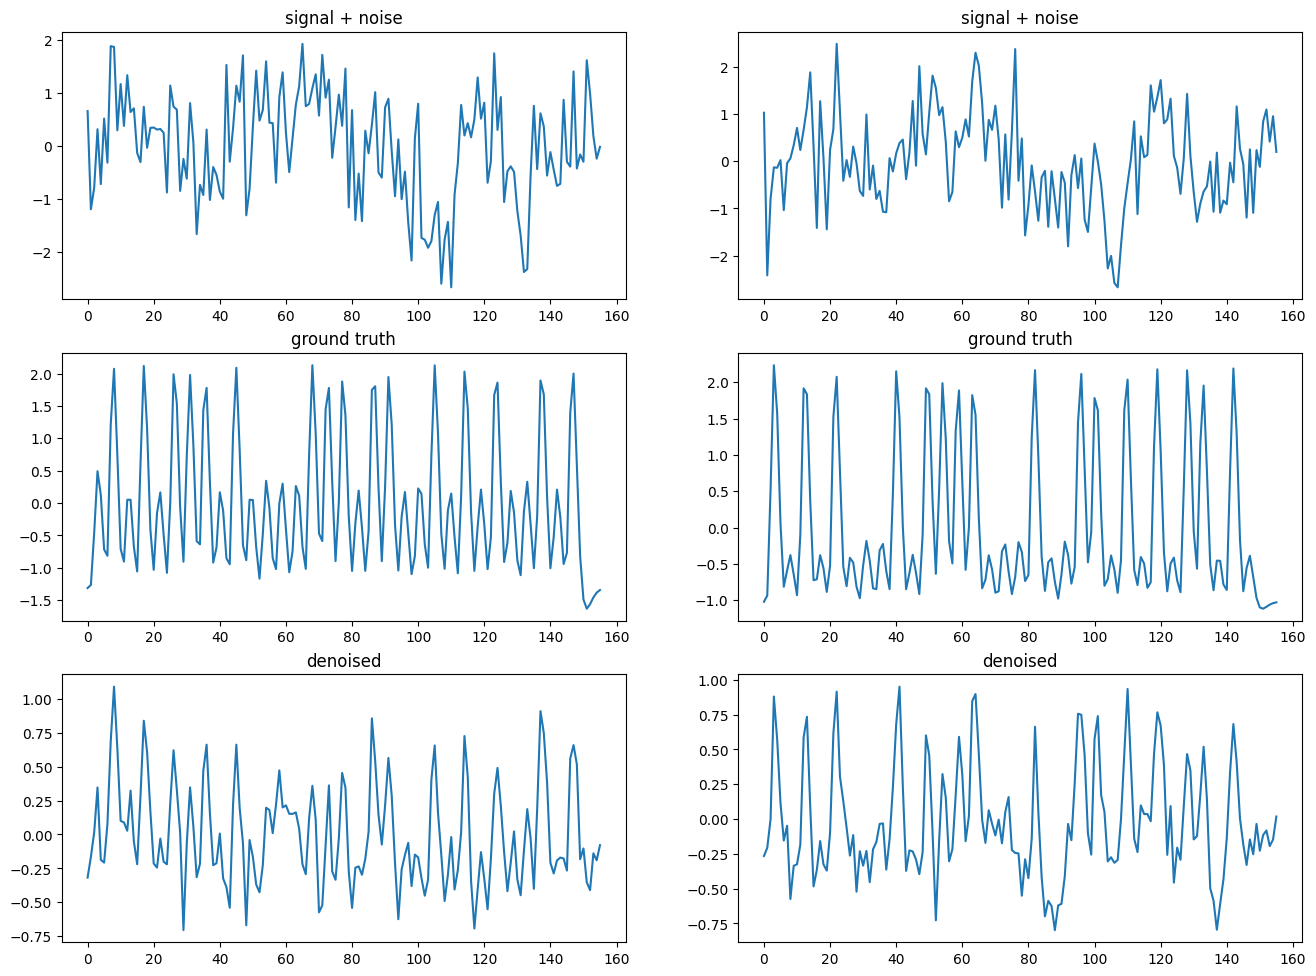

In [12]:
# visualize some output voxels
import matplotlib.pyplot as plt
outputs_test_40 = model.generate(torch.tensor(obs_list[40]).unsqueeze(0).unsqueeze(0).float().to('cuda:0'))
outputs_test_2 = model.generate(torch.tensor(obs_list[2]).unsqueeze(0).unsqueeze(0).float().to('cuda:0'))
x = [i for i in range(156)]
plt.figure(figsize = (16,16))
plt.subplot(4,2,1)
plt.plot(x,obs_list[40][0:156],'-')
plt.title('signal + noise')
plt.subplot(4,2,2)
plt.plot(x,obs_list[2][0:156],'-')
plt.title('signal + noise')
plt.subplot(4,2,3)
plt.plot(x,gt_list[40][0:156],'-')
plt.title('ground truth')
plt.subplot(4,2,4)
plt.plot(x,gt_list[2][0:156],'-')
plt.title('ground truth')
plt.subplot(4,2,5)
plt.plot(x,outputs_test_40.squeeze().cpu().detach().numpy(),'-')
plt.title('denoised')
plt.subplot(4,2,6)
plt.plot(x,outputs_test_2.squeeze().cpu().detach().numpy(),'-')
plt.title('denoised')

### 3. Example on the real resting fMRI
Now we give an example to run DeepCor on the real resting fMRI. Users should replace the path to their own anatomical MRI, fMRI, and probabilti map for GM (gray matter), WM (white matter), and CSF (cerebrospinal fluid).

#### 3.1 Import modules

In [1]:
import DeepCor
import torch
import numpy as np
import random
import os
from torch.utils.data import random_split
from numpy import savetxt
import matplotlib.pyplot as plt 
import nibabel as nib
import nibabel.processing as nibp
from scipy import signal
from itertools import combinations_with_replacement


#### 3.2 Load the data

In [2]:
# define input file path. Users should replace by their own path.
filepath_anat = 'path_to_your_anatomical_MRI'
filepath_gm = 'path_to_your_GM_prob_map'
filepath_wm = 'path_to_your_WM_prob_map'
filepath_csf = 'path_to_your_CSF_prob_map'
filepath_func = 'path_to_your_resting_stat_fMRI'


In [3]:
filepath = './sample_data/'
par_num = 'sub-0050002'
filepath_anat = filepath+'/'+par_num+ '/anat/'+par_num+'_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz'
filepath_gm = filepath+'/'+par_num+ '/anat/'+par_num+'_space-MNI152NLin2009cAsym_res-2_label-GM_probseg.nii.gz'
filepath_wm = filepath+'/'+par_num+ '/anat/'+par_num+'_space-MNI152NLin2009cAsym_res-2_label-WM_probseg.nii.gz'
filepath_csf = filepath+'/'+par_num+ '/anat/'+par_num+'_space-MNI152NLin2009cAsym_res-2_label-CSF_probseg.nii.gz'
filepath_func = filepath+'/'+par_num+ '/func/'+par_num+'_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'

In [4]:
# load data
anat = nib.load(filepath_anat)
gm = nib.load(filepath_gm)
wm = nib.load(filepath_wm)
csf = nib.load(filepath_csf)
func = nib.load(filepath_func)

In [5]:
# transform probabiltiy map to the mask
gm_values = gm.get_fdata()
gm_mask = (gm_values>0.5)
wm_values = wm.get_fdata()
csf_values = csf.get_fdata()
cf_values = wm_values+csf_values
cf_mask = (cf_values>0.5)

In [6]:
# remove the overlapped voxels
diff = gm_mask & cf_mask
gm_mask_c = gm_mask ^ diff
cf_mask_c = cf_mask ^ diff

In [7]:
# Extract functional data from masks
# first five time points have been removed
func_values = func.get_fdata()[:,:,:,5:]
func_reshaped = np.reshape(func_values,[func.shape[0]*func.shape[1]*func.shape[2],func.shape[3]-5])
gm_reshaped = np.reshape(gm_mask_c,-1)
cf_reshaped = np.reshape(cf_mask_c,-1)
func_gm = func_reshaped[gm_reshaped,:] # these are the functional data in gray matter
func_cf = func_reshaped[cf_reshaped,:] # these are the functional data in the regions of no interest

In [8]:
#Normalization of Data
func_gm, _  = DeepCor.remove_std0(func_gm)
func_cf, _ = DeepCor.remove_std0(func_cf)

obs_scale = DeepCor.Scaler(func_gm)
obs_list = obs_scale.transform(func_gm)
noi_scale = DeepCor.Scaler(func_cf)
noi_list = noi_scale.transform(func_cf)

In [9]:
# dataloading
inputs_all = DeepCor.TrainDataset_real(obs_list,noi_list)

train_num = int(0.80*obs_list.shape[0])
val_num = int(0.2*obs_list.shape[0])
total_num_samples = val_num + train_num
selected_indices = np.random.choice(len(inputs_all), size=total_num_samples, replace=False)
selected_samples = torch.utils.data.Subset(inputs_all, selected_indices)

generator = torch.Generator().manual_seed(42)
train_inputs, val_inputs = random_split(selected_samples, [train_num, val_num], generator=generator)
print("Train number is "+str(len(train_inputs)))
print("Val number is "+str(len(val_inputs)))
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=64,
                                                shuffle=True, num_workers=1)
val_in = torch.utils.data.DataLoader(val_inputs, batch_size=64,
                                                shuffle=True, num_workers=1)



Train number is 87568
Val number is 21892


#### 3.3 Training with the DeepCor

In [10]:
latent_dim = 8
in_dim = obs_list.shape[1] # the time course length
DeepCorTrainer = DeepCor.DeepCorTrainer(latent_dim, in_dim) # initiate the model
model = DeepCorTrainer.train_real(train_in, val_in) # training the model with training and validation data

Current device: cuda:0


/oscar/data/yma16/yzhu194/DeepCor_test/deepcor/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


Epoch 1/200
----------
Train Loss: 0.6749, Recon: 0.6739, KLD: 95.7275
Val Loss:   1.2661, Recon: 1.2643, KLD: 177.9650

Epoch 2/200
----------
Train Loss: 0.6534, Recon: 0.6525, KLD: 94.2466
Val Loss:   1.1706, Recon: 1.1687, KLD: 189.4239

Epoch 3/200
----------
Train Loss: 0.6506, Recon: 0.6498, KLD: 87.3361
Val Loss:   1.4580, Recon: 1.4562, KLD: 181.1674

Epoch 4/200
----------
Train Loss: 0.6471, Recon: 0.6463, KLD: 81.9645
Val Loss:   1.1947, Recon: 1.1930, KLD: 171.9386

Epoch 5/200
----------
Train Loss: 0.6465, Recon: 0.6457, KLD: 78.6377
Val Loss:   1.2909, Recon: 1.2893, KLD: 160.0868

Epoch 6/200
----------
Train Loss: 0.6449, Recon: 0.6441, KLD: 76.0151
Val Loss:   1.2788, Recon: 1.2773, KLD: 147.3353

Epoch 7/200
----------
Train Loss: 0.6442, Recon: 0.6434, KLD: 74.6578
Val Loss:   1.1838, Recon: 1.1823, KLD: 148.5659

Epoch 8/200
----------
Train Loss: 0.6439, Recon: 0.6431, KLD: 73.1127
Val Loss:   1.3035, Recon: 1.3020, KLD: 146.7328

Epoch 9/200
----------
Train Los

#### 3.4 Denoising the interested region
 After the model is trained, we can use DeepCor to denoise certain region's voxel that we're interested. We give a example of denoising Dorsal Attention Network (DAN) using Yeo's 7-Network Atlas.

In [11]:
# to get the ROI mask, install nilearn
! pip install nilearn

You should consider upgrading via the '/oscar/data/yma16/yzhu194/DeepCor_test/deepcor/bin/python3 -m pip install --upgrade pip' command.


In [12]:
from nilearn import datasets, plotting
from nilearn.input_data import NiftiMasker

# Load the Yeo 2011 7-network atlas and select DAN region
yeo_atlas_7 = datasets.fetch_atlas_yeo_2011()
yeo_atlas_img = yeo_atlas_7.thin_7
yeo_img = nib.load(yeo_atlas_img)
yeo_data = yeo_img.get_fdata()
dan_mask_data = np.where(yeo_data == 2, 1, 0)
dan_mask_data = dan_mask_data.astype(np.uint8)
dan_mask_img = nib.Nifti1Image(dan_mask_data, yeo_img.affine)


[get_dataset_dir] Dataset found in /users/yzhu194/nilearn_data/yeo_2011


In [13]:
#transform the func to anatomical map
nifti_masker = NiftiMasker(mask_img=dan_mask_img)
func_resize = nifti_masker.fit_transform(func)

/oscar/data/yma16/yzhu194/DeepCor_test/deepcor/lib64/python3.9/site-packages/nilearn/maskers/nifti_masker.py:114: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


[NiftiMasker.wrapped] Resampling images


In [14]:
# prepare the voxels from interested region
func_resize = func_resize.T[:,5:] # remove the first 5 voxels
func_scale = DeepCor.Scaler(func_resize)
func_in = func_scale.transform(func_resize)
denoise_inputs = DeepCor.DenoiseDataset(func_in)
denoise_in = torch.utils.data.DataLoader(denoise_inputs, batch_size=64,
                                                shuffle=False, num_workers=1)

/oscar/data/yma16/yzhu194/DeepCor_test/DeepCor_pkg/DeepCor/utils.py:87: RuntimeWarning: invalid value encountered in divide
  return np.divide(inputs-self.m_large,self.s_large)


In [15]:
# denoise the voxels
denoise_iter_in = iter(denoise_in)
for i in range(len(denoise_in)):
    inputs = next(denoise_iter_in)
    inputs = inputs.unsqueeze(1).float().to('cuda:0')
    func_output = model.generate(inputs)
    func_output_np = func_output.squeeze().cpu().detach().numpy()
    if i == 0:
        outputs_all = func_output_np 
    else:
        outputs_all = np.concatenate((outputs_all,func_output_np), axis = 0)

Text(0.5, 1.0, 'denoised')

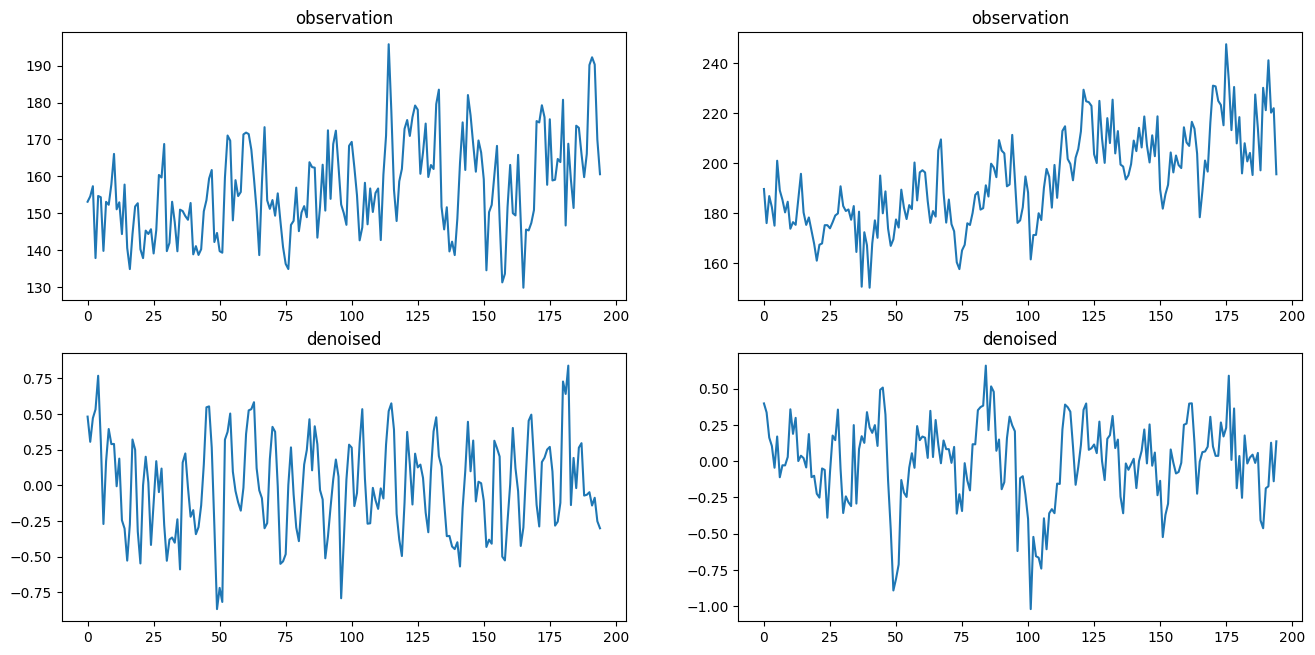

In [16]:
# visualize some output voxels
import matplotlib.pyplot as plt
x = [i for i in range(func_resize.shape[1])]
plt.figure(figsize = (16,16))
plt.subplot(4,2,1)
plt.plot(x,func_resize[40],'-')
plt.title('observation')
plt.subplot(4,2,2)
plt.plot(x,func_resize[2],'-')
plt.title('observation')
plt.subplot(4,2,3)
plt.plot(x,outputs_all[40],'-')
plt.title('denoised')
plt.subplot(4,2,4)
plt.plot(x,outputs_all[2],'-')
plt.title('denoised')